In [44]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
import keras
from keras import layers
from keras.layers import Activation, Dense
from keras.optimizers import RMSprop
import rbflayer, kmeans_initializer
from rbflayer import InitCentersRandom
from keras.initializers import RandomUniform, Initializer, Constant

from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, Activation, Dropout
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from scipy import * 
from scipy.linalg import norm, pinv
from matplotlib import pyplot as plt  
import warnings
warnings.filterwarnings("ignore")

In [45]:
import pandas as pd
import pyarrow.parquet as pq # Used to read the data
import os 
import numpy as np
from keras.layers import * # Keras is the most friendly Neural Network library, this Kernel use a lot of layers classes
from keras.models import Model
from tqdm import tqdm # Processing time measurement
from sklearn.model_selection import train_test_split 
from keras import backend as K # The backend give us access to tensorflow operations and allow us to create the Attention class
from keras import optimizers # Allow us to access the Adam class to modify some parameters
from sklearn.model_selection import GridSearchCV, StratifiedKFold # Used to use Kfold to train our model
from keras.callbacks import * # This object helps the model to train in a smarter way, avoiding overfitting

In [46]:
from tensorflow.compat.v1.keras.layers import CuDNNGRU
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from keras.layers import SpatialDropout1D
from keras import initializers,regularizers,constraints

In [47]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["CUDA_VISIBLE_DEVICE"]  = '0'

In [57]:
Feature_A = pd.read_excel(io=r'C:\Users\Serendipity\Attention_RBF\Feature_A.xlsx')
Feature_B = pd.read_excel(io=r'C:\Users\Serendipity\Attention_RBF\Feature_B.xlsx')
Feature_C = pd.read_excel(io=r'C:\Users\Serendipity\Attention_RBF\Feature_c.xlsx')

In [58]:
Feature_A = Feature_A.rename(columns={"Isa_A": "Isa", "Isd_A": "Isd","Iar_A": "Iar","Pvd_A": "Pvd","θ_A":"θ"})
Feature_B = Feature_B.rename(columns={"Isa_B": "Isa", "Isd_B": "Isd","Iar_B": "Iar","Pvd_B": "Pvd","θ_B":"θ"})
Feature_C = Feature_C.rename(columns={"Isa_C": "Isa", "Isd_C": "Isd","Iar_C": "Iar","Pvd_C": "Pvd","θ_C":"θ"})

In [59]:
Feature = pd.concat([
    Feature_A,
    Feature_B,
    Feature_C,
]) 

In [60]:
label_y = Feature['label']
X_feat =  Feature[['负载率','Isa','三相电流不平衡度','Isd','Iar','Pvd','负载率差值','θ']]
# float64->float32
#X_feat[X_feat.select_dtypes(np.float64).columns] = X_feat.select_dtypes(np.float64).astype(np.float32)

# inf,nan数据填充
X_feat = (X_feat.replace([np.inf, -np.inf], np.nan)).fillna(value = 0) 

# SMOTE样本均衡化

In [61]:
from collections import Counter
# 查看所生成的样本类别分布，0和1样本比例9比1，属于类别不平衡数据
print(Counter(label_y))
# Counter({0: 900, 1: 100})

Counter({0: 149618, 1: 1834})


In [62]:
# 使用imlbearn库中上采样方法中的SMOTE接口
from imblearn.over_sampling import SMOTE
# 定义SMOTE模型，random_state相当于随机数种子的作用
smo = SMOTE(random_state=42)
X_smo, y_smo = smo.fit_resample(X_feat, label_y)

In [63]:
print(Counter(y_smo))
# Counter({0: 900, 1: 100})

Counter({0: 149618, 1: 149618})


In [64]:
scaler = MinMaxScaler((0,1))

lb = LabelEncoder()

In [65]:
X_smo

,负载率,Isa,三相电流不平衡度,Isd,Iar,Pvd,负载率差值,θ
0,14.373800,0.000000,0.221106,0.000000,0.128571,0.000222,-1.659500,0.006229
1,12.714300,-7.931262,0.372881,-6.172840,0.128571,0.000222,1.227800,-0.078344
2,13.942100,-14.276272,0.316327,-10.465116,0.136508,0.000270,1.853900,-0.140728
3,15.796000,38.070059,0.295455,25.263158,0.150794,0.000413,-3.316500,0.353894
4,12.479500,3.172505,0.231214,2.816901,0.112698,0.000032,-0.261900,0.034775
...,...,...,...,...,...,...,...,...
299231,16.318183,-22.278998,0.251495,-20.864044,0.146751,0.000391,1.918612,-0.218812
299232,5.064354,-84.854526,0.279909,-151.887609,0.036940,0.000578,2.766760,-0.700622
299233,19.471195,-23.951392,0.386530,-17.749873,0.091627,0.000229,1.796548,-0.233068
299234,18.119446,-50.202186,0.568227,-132.136228,0.076000,0.001348,14.167156,-0.457158


# Attention

In [66]:
# https://www.kaggle.com/suicaokhoailang/lstm-attention-baseline-0-652-lb

class Attention(keras.layers.Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape = (input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [67]:
# This is NN LSTM Model creation
def model_lstm(input_shape):
    # The shape was explained above, must have this order
    inp = Input(shape=(input_shape[1], input_shape[2],))
    # This is the LSTM layer
    # Bidirecional implies that the 160 chunks are calculated in both ways, 0 to 159 and 159 to zero
    # although it appear that just 0 to 159 way matter, I have tested with and without, and tha later worked best
    # 128 and 64 are the number of cells used, too many can overfit and too few can underfit
    x = Bidirectional(CuDNNLSTM(128, return_sequences=True))(inp)
    # The second LSTM can give more fire power to the model, but can overfit it too
    x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)
    # Attention is a new tecnology that can be applyed to a Recurrent NN to give more meanings to a signal found in the middle
    # of the data, it helps more in longs chains of data. A normal RNN give all the responsibility of detect the signal
    # to the last cell. Google RNN Attention for more information :)
    x = Attention(input_shape[1])(x)
    # A intermediate full connected (Dense) can help to deal with nonlinears outputs
    x = Dense(64, activation="relu")(x)
    # A binnary classification as this must finish with shape (1,)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    # Pay attention in the addition of matthews_correlation metric in the compilation, it is a success factor key
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[matthews_correlation])
    
    return model

In [68]:
# select how many folds will be created
N_SPLITS = 5
# it is just a constant with the measurements data size
X = np.reshape(X_smo.values,(-1,8,1))

In [69]:
# It is the official metric used in this competition
# below is the declaration of a function used inside the keras model, calculation with K (keras backend / thensorflow)
def matthews_correlation(y_true, y_pred):
    '''Calculates the Matthews correlation coefficient measure for quality
    of binary classification problems.
    '''
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

In [70]:
# Here is where the training happens

# First, create a set of indexes of the 5 folds
splits = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=2019).split(X, y_smo))
preds_val = []
y_val = []
# Then, iteract with each fold
# If you dont know, enumerate(['a', 'b', 'c']) returns [(0, 'a'), (1, 'b'), (2, 'c')]
for idx, (train_idx, val_idx) in enumerate(splits):
    K.clear_session() # I dont know what it do, but I imagine that it "clear session" :)
    print("Beginning fold {}".format(idx+1))
    # use the indexes to extract the folds in the train and validation data
    train_X, train_y, val_X, val_y = X[train_idx], y_smo[train_idx], X[val_idx], y_smo[val_idx]
    # instantiate the model for this fold
    model = model_lstm(train_X.shape)
    # This checkpoint helps to avoid overfitting. It just save the weights of the model if it delivered an
    # validation matthews_correlation greater than the last one.
    ckpt = ModelCheckpoint('weights_{}.h5'.format(idx), save_best_only=True, save_weights_only=True, verbose=1, monitor='val_matthews_correlation', mode='max')
    # Train, train, train
    model.fit(train_X, train_y, batch_size=1024, epochs=100, validation_data=[val_X, val_y], callbacks=[ckpt])
    # loads the best weights saved by the checkpoint
    model.load_weights('weights_{}.h5'.format(idx))
    # Add the predictions of the validation to the list preds_val
    preds_val.append(model.predict(val_X, batch_size=512))
    # and the val true y
    y_val.append(val_y)

# concatenates all and prints the shape    
preds_val = np.concatenate(preds_val)[...,0]
y_val = np.concatenate(y_val)
preds_val.shape, y_val.shape

Beginning fold 1
Train on 239388 samples, validate on 59848 samples
Epoch 1/100
239388/239388 [==============================] - ETA: 0s - loss: 0.6178 - matthews_correlation: 0.3334
Epoch 00001: val_matthews_correlation improved from -inf to 0.33848, saving model to weights_0.h5
239388/239388 [==============================] - 12s 51us/sample - loss: 0.6178 - matthews_correlation: 0.3334 - val_loss: 0.6128 - val_matthews_correlation: 0.3385
Epoch 2/100
237568/239388 [============================>.] - ETA: 0s - loss: 0.6019 - matthews_correlation: 0.3524
Epoch 00002: val_matthews_correlation improved from 0.33848 to 0.35508, saving model to weights_0.h5
239388/239388 [==============================] - 7s 27us/sample - loss: 0.6019 - matthews_correlation: 0.3522 - val_loss: 0.5948 - val_matthews_correlation: 0.3551
Epoch 3/100
237568/239388 [============================>.] - ETA: 0s - loss: 0.5872 - matthews_correlation: 0.3650
Epoch 00003: val_matthews_correlation improved from 0.35508

((299236,), (299236,))

In [71]:
y_pred = model.predict(val_X, batch_size=512)

In [72]:
def argmax(y_pred):
    for i in range(y_pred.shape[0]):
        if(y_pred[i]<0.5):
            y_pred[i] = 0
        else:
            y_pred[i] = 1
    return y_pred

In [73]:
y_pred = argmax(y_pred).reshape(y_pred.shape[0],)

In [74]:
print(Counter(y_pred))

Counter({1.0: 31075, 0.0: 28772})


In [75]:
y_test = val_y

In [76]:
# Calculate metrics
from sklearn.metrics import accuracy_score
from sklearn import datasets,model_selection,metrics,tree,preprocessing
acc = accuracy_score(y_test,y_pred)

from sklearn.metrics import precision_score
precision = precision_score(y_test,y_pred,average='binary')

recall = metrics.recall_score(y_test,y_pred, average='macro')

fscore = metrics.f1_score(y_test,y_pred, average='weighted')

In [77]:
acc,precision,recall,fscore

(0.957508312864471, 0.9405631536604988, 0.9575079914935435, 0.9574925763713762)

In [37]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7, 1)]            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 7, 256)            134144    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 7, 128)            164864    
_________________________________________________________________
attention (Attention)        (None, 128)               135       
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 307,464
Trainable params: 307,464
Non-trainable params: 0
________________________________________________

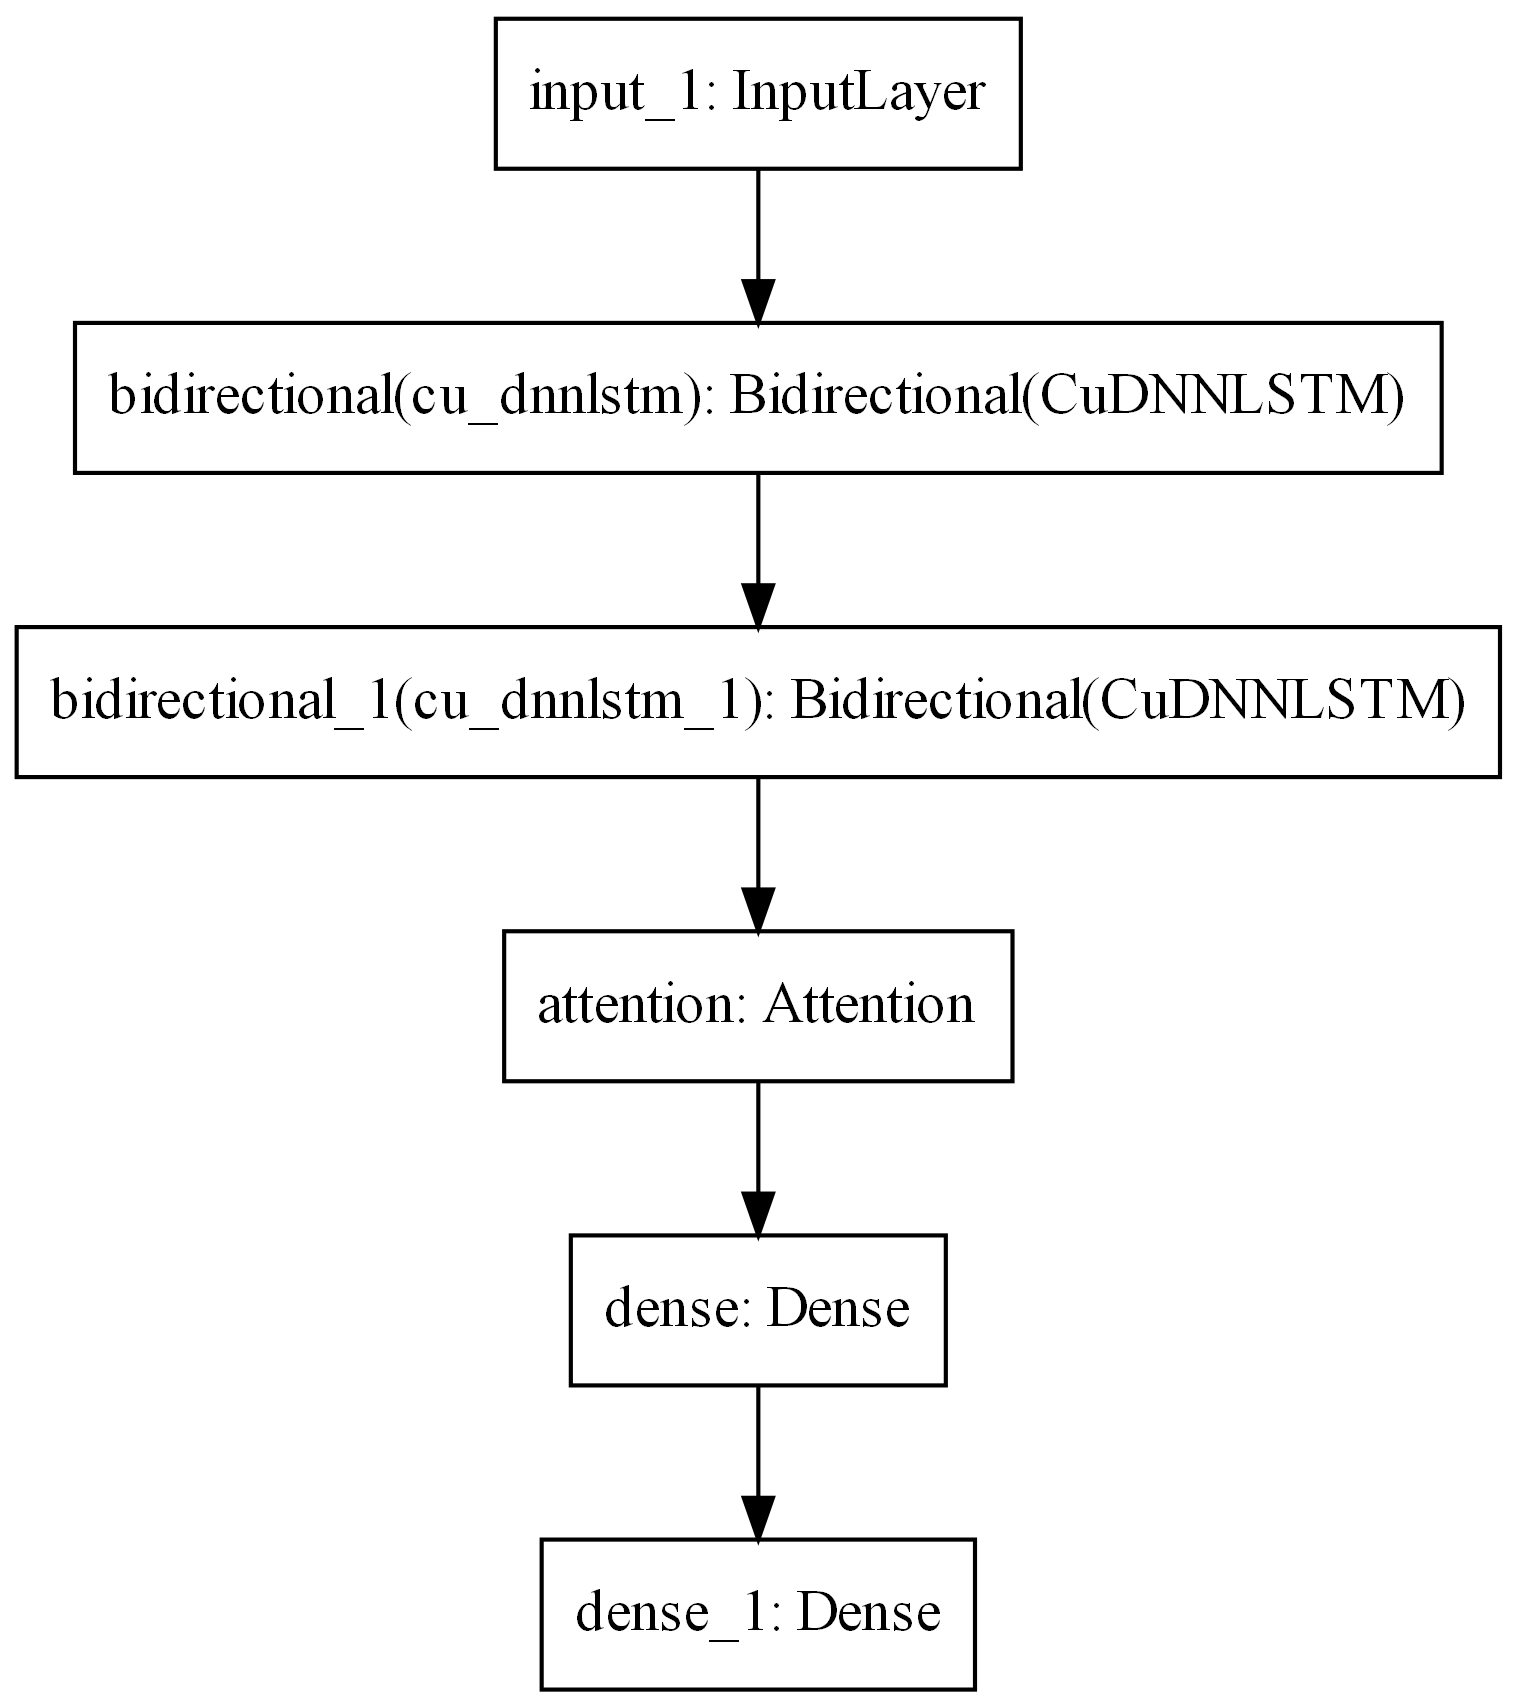

In [43]:
from keras.utils import plot_model
plot_model(model, to_file='model.png',dpi=300)